This notebook contains all the experimentation work done for the final custom models prepared for talewind's backend.

In [47]:
# imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import datetime

# specific imports
from keras.models import Sequential
from keras.layers import LSTMV2, Dense, Dropout, Input
from spacy import displacy
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sentence_transformers import SentenceTransformer
from nltk.tokenize import PunktSentenceTokenizer as pkt
from IPython.display import clear_output

# deprecated imports
from bs4 import BeautifulSoup
from urllib.request import urlopen

MODEL_ID = 'sentence-transformers/all-MiniLM-L6-v2'

In [2]:
df1 = pd.read_csv('./datasets/newsArticlesWithLabels.tsv', delimiter='\t')
df1.head()

,url,q3,perceived,primary.topic,secondary.topic,democrat.vote,republican.vote
0,http://www.usatoday.com/story/news/nation/2013...,other,1,Civil Rights,Civil Rights,Neutral,Neutral
1,http://www.huffingtonpost.com/2013/05/21/senat...,News,0,Civil Rights,Civil Rights,Neutral,Neutral
2,http://www.washingtonpost.com/opinions/dont-le...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
3,http://www.foxnews.com/politics/2013/04/03/oba...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral
4,http://www.breitbart.com/Big-Government/2013/1...,Opinion,1,Civil Rights,Civil Rights,Neutral,Neutral


In [3]:
df1.shape

(21004, 7)

In [4]:
url = df1['url'][1]
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")
print(soup.get_text())

Senate Immigration Bill Passes Out Of Judiciary Committee | HuffPost Latest News





Skip to Main Content×Main MenuU.S. EditionNewsU.S. NewsWorld NewsBusinessEnvironmentHealthCoronavirusSocial JusticePoliticsJoe BidenCongressExtremismElections 2022OpinionEntertainmentCulture & ArtsMediaCelebrityTV & FilmLifeStyle & BeautyFood & DrinkParentingTravelWellnessRelationshipsMoneyHome & LivingWork/LifeShoppingVoicesQueer VoicesWomen's VoicesBlack VoicesLatino VoicesAsian VoicesSpecial ProjectsHighlineHuffPost PersonalHoroscopesFrom Our PartnersMemories In The MakingThe Stories Of UsNewslettersInternationalAustraliaBrazilCanadaEspañaFranceΕλλάδα (Greece)IndiaItalia日本 (Japan)한국 (Korea)QuébecU.K.U.S.Follow UsTerms | Privacy PolicyPart of HuffPost Politics. ©2023 BuzzFeed, Inc. All rights reserved.Log InJoin HuffPostNEWSPOLITICSENTERTAINMENTLIFEPERSONALVOICESSHOPPINGVIDEOU.S. EditionOpen editions submenu×What's HotJimmy Kimmel Spots Most Cringeworthy MAGA Moment Yet From 'Trumpy Dopes'Met Gala 2

### scraping here is way too time consuming and not useful, so we will try the other datasets first.

In [5]:
df2 = pd.read_csv('./datasets/labeled_dataset.csv')
df2.head()

,Unnamed: 0,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4
0,0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter']
2,2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis']
3,3,A professor who teaches climate change classes...,https://www.breitbart.com/politics/2019/05/09/...,breitbart,environment,right,1,1,Non-biased,No agreement,A professor who teaches climate change classes...,['legitimate']
4,4,"Looking around the United States, there is nev...",https://thefederalist.com/2020/03/11/woman-who...,federalist,abortion,right,1,1,Biased,Somewhat factual but also opinionated,The left has a thing for taking babies hostage...,"['killing', 'never', 'developing', 'humans', '..."


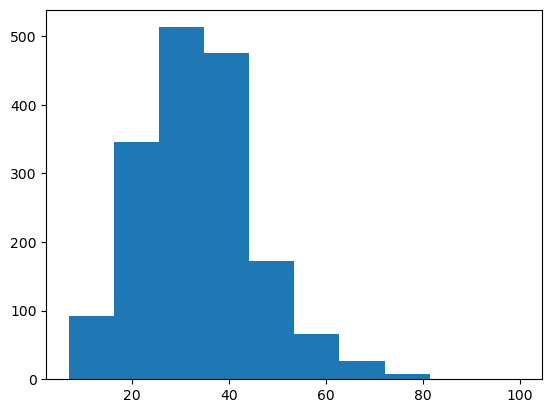

count    1700.000000
mean       33.481765
std        11.933266
min         7.000000
25%        25.000000
50%        33.000000
75%        40.000000
max       100.000000
Name: sentence, dtype: float64


In [6]:
# counting the number of words in sequences.
plt.hist(df2['sentence'].apply(lambda x: len(x.split(' '))))
plt.show()
print(df2['sentence'].apply(lambda x: len(x.split(' '))).describe())

In [7]:
# based on that data, we can safely set the max length of sequences to 128
MAX_LENGTH = 128

In [8]:
onehotencode = pd.get_dummies(df2.iloc[:, 8:10])
nonagree = onehotencode.iloc[:, [1, 5]]

In [9]:
pd.concat([df2['sentence'], onehotencode], axis=1).head()

,sentence,Label_bias_Biased,Label_bias_No agreement,Label_bias_Non-biased,Label_opinion_Entirely factual,Label_opinion_Expresses writer’s opinion,Label_opinion_No agreement,Label_opinion_Somewhat factual but also opinionated
0,YouTube is making clear there will be no “birt...,1,0,0,0,0,0,1
1,The increasingly bitter dispute between Americ...,0,0,1,1,0,0,0
2,So while there may be a humanitarian crisis dr...,1,0,0,0,1,0,0
3,A professor who teaches climate change classes...,0,0,1,0,0,1,0
4,"Looking around the United States, there is nev...",1,0,0,0,0,0,1


In [10]:
onehotencode.sum()

Label_bias_Biased                                      1018
Label_bias_No agreement                                 149
Label_bias_Non-biased                                   533
Label_opinion_Entirely factual                          572
Label_opinion_Expresses writer’s opinion                521
Label_opinion_No agreement                              174
Label_opinion_Somewhat factual but also opinionated     433
dtype: int64

one hot encoding based on combination, to see if the results are better.

In [11]:
combinations = []
for i, j in df2.iloc[:, 8:10].iterrows():
    combinations.append(j[0] + '_' + j[1])
(pd.get_dummies(combinations) == 1).sum()

Biased_Entirely factual                                70
Biased_Expresses writer’s opinion                     491
Biased_No agreement                                   107
Biased_Somewhat factual but also opinionated          350
No agreement_Entirely factual                          64
No agreement_Expresses writer’s opinion                18
No agreement_No agreement                              29
No agreement_Somewhat factual but also opinionated     38
Non-biased_Entirely factual                           438
Non-biased_Expresses writer’s opinion                  12
Non-biased_No agreement                                38
Non-biased_Somewhat factual but also opinionated       45
dtype: int64

- this is not nearly enough data either way, so we will be synthesizing our own dataset to work on for the purposes of this project.

Since i already know what the data structure is going to be like, i can simply already work on the structure of the model and what the output would look like.

In [12]:
sample_dataset = pd.read_csv('./datasets/synthesized_dataset.csv')
sample_dataset.head()

,Sentence,Content Bias,Partisan Bias,False balance,Ventriloquism,Demographic bias,Undue Weight,Corporate
0,The president's speech yesterday was an absolu...,1,1,0,0,0,0,0
1,"Climate change is a controversial issue, with ...",0,0,1,0,0,0,0
2,"In a groundbreaking move, the company announce...",0,0,0,0,1,0,1
3,"Despite widespread opposition, the oil company...",1,0,0,0,0,1,1
4,The senator's recent tweet demonstrates her un...,0,1,0,0,0,0,0


- this is a very small sample of what the dataset would be like. we'll find manual thresholds for what values should flag as biases.

In [13]:
sample_dataset.shape

(4010, 8)

In [14]:
print(f"Number of Repeats: {sample_dataset.shape[0] - len(sample_dataset['Sentence'].unique())}")
print(f"Number of Unique Sentences: {len(sample_dataset['Sentence'].unique())}")

Number of Repeats: 2455
Number of Unique Sentences: 1555


In [15]:
sample_dataset.dtypes

Sentence            object
Content Bias         int64
Partisan Bias        int64
False balance        int64
Ventriloquism        int64
Demographic bias     int64
Undue Weight         int64
Corporate            int64
dtype: object

In [16]:
sample_dataset.isna().sum()

Sentence            0
Content Bias        0
Partisan Bias       0
False balance       0
Ventriloquism       0
Demographic bias    0
Undue Weight        0
Corporate           0
dtype: int64

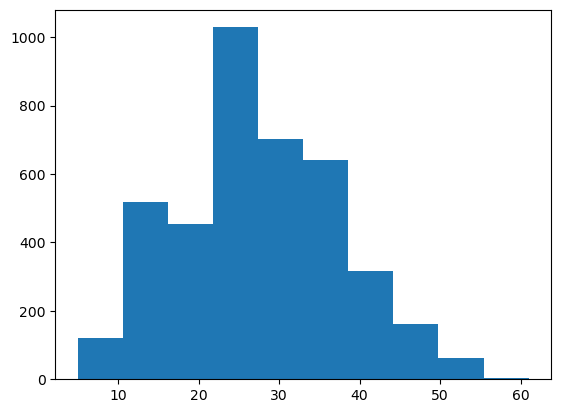

In [17]:
plt.hist(sample_dataset['Sentence'].apply(lambda x: len(x.split(' '))))
plt.show()

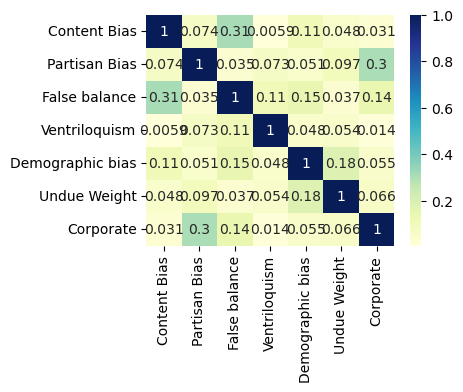

In [18]:
fig = plt.figure(figsize=(4, 3))
corr = sample_dataset.iloc[:, 1:].corr().apply(abs)
dataplot = sns.heatmap(corr, cmap="YlGnBu", annot=True)

this good, we have a decent variance in the data as well.

In [19]:
sample_dataset.iloc[:, 1:].sum() / len(sample_dataset)

Content Bias        0.217456
Partisan Bias       0.191272
False balance       0.133666
Ventriloquism       0.029426
Demographic bias    0.296259
Undue Weight        0.211970
Corporate           0.369327
dtype: float64

In [43]:
sample_dataset.columns

Index(['Sentence', 'Content Bias', 'Partisan Bias', 'False balance',
       'Ventriloquism', 'Demographic bias', 'Undue Weight', 'Corporate'],
      dtype='object')

unbalanced, but it will have to do for now.

a slight detour, for text seperation and then span assignment

In [20]:
text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.'
sentarray = np.array(pkt().tokenize(text))
sentspan = np.array([i for i in pkt().span_tokenize(text)])
sentarray.shape[0] == sentspan.shape[0]

True

In [21]:
nlp = spacy.blank("en")
doc = nlp(text)

doc.spans["sc"] = []
for i in range(len(sentarray)):
    doc.spans["sc"].append(doc.char_span(sentspan[i][0], sentspan[i][1], "sentence number " + str(i)))
html = displacy.render(doc, style="span", page=True, minify=False, jupyter=False)
print(html)

<!DOCTYPE html>
<html lang="en">
    <head>
        <title>displaCy</title>
    </head>

    <body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol'; padding: 4rem 2rem; direction: ltr">
<figure style="margin-bottom: 6rem">
<div class="spans" style="line-height: 2.5; direction: ltr">
<span style="font-weight: bold; display: inline-block; position: relative; height: 60px;">
    Lorem
    
<span style="background: #ddd; top: 40px; height: 4px; left: -1px; width: calc(100% + 2px); position: absolute;">
</span>

    
<span style="background: #ddd; top: 40px; height: 4px; border-top-left-radius: 3px; border-bottom-left-radius: 3px; left: -1px; width: calc(100% + 2px); position: absolute;">
    <span style="background: #ddd; z-index: 10; color: #000; top: -0.5em; padding: 2px 3px; position: absolute; font-size: 0.6em; font-weight: bold; line-height: 1; border-radius: 3px">

testing ent display

In [22]:
ex = [{"text": text,
       "ents": [],
       "title": None}]

for i in range(len(sentarray)):
    ex[0]["ents"].append({"start" : sentspan[i][0], "end" : sentspan[i][1], "label" : "sentence " + str(i)})

html = displacy.render(ex, style="ent", manual=True, page=True, minify=False, jupyter=False)
print(html)

<!DOCTYPE html>
<html lang="en">
    <head>
        <title>displaCy</title>
    </head>

    <body style="font-size: 16px; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol'; padding: 4rem 2rem; direction: ltr">
<figure style="margin-bottom: 6rem">
<div class="entities" style="line-height: 2.5; direction: ltr">
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua.
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; vertical-align: middle; margin-left: 0.5rem">sentence 0</span>
</mark>
 
<mark class="entity" style="background: #ddd; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em;">
    Ut enim ad minim veniam, quis nostrud

Back to AI work, this will be used to generate the sentence wise analysis and sent as-is in the JSON. Let's remove the duplicates from our data

In [23]:
sample_dataset = sample_dataset.drop_duplicates().reset_index(drop=True)
sample_dataset.to_csv('./datasets/Filtered_synthesized_dataset.csv')
sample_dataset.head()

,Sentence,Content Bias,Partisan Bias,False balance,Ventriloquism,Demographic bias,Undue Weight,Corporate
0,The president's speech yesterday was an absolu...,1,1,0,0,0,0,0
1,"Climate change is a controversial issue, with ...",0,0,1,0,0,0,0
2,"In a groundbreaking move, the company announce...",0,0,0,0,1,0,1
3,"Despite widespread opposition, the oil company...",1,0,0,0,0,1,1
4,The senator's recent tweet demonstrates her un...,0,1,0,0,0,0,0


- making a custom class for the sentence embedding layer.

In [24]:
# Load model and tokenizer
model = SentenceTransformer(MODEL_ID)

# Run inference & create embeddings
payload = ["This is a sentence embedding",
           "This is another sentence embedding"]
sentence_embedding = model.encode(payload)

print(sentence_embedding.shape)

(2, 384)


In [25]:
X = model.encode(sample_dataset['Sentence'])
y = sample_dataset.iloc[:, 1:]
X.shape, y.shape

((1557, 384), (1557, 7))

- another detour, making custom tensorboard functions and logs.

In [27]:
# custom class to plot all metrics while learning.
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(21,6))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

model

In [69]:
bias_model = Sequential()
bias_model.add(Input((384)))
bias_model.add(Dense(384, activation='relu'))
bias_model.add(Dropout(0.1))
bias_model.add(Dense(128, activation='relu'))
bias_model.add(Dropout(0.1))
bias_model.add(Dense(32, activation='relu'))
bias_model.add(Dense(7, activation='softmax'))
bias_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])
bias_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 384)               147840    
                                                                 
 dropout_10 (Dropout)        (None, 384)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               49280     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 32)                4128      
                                                                 
 dense_27 (Dense)            (None, 7)                 231       
                                                                 
Total params: 201,479
Trainable params: 201,479
Non-tr

In [70]:
%reload_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = bias_model.fit(X, y, epochs=50, batch_size=1, shuffle=True, callbacks=[tensorboard_callback])

Epoch 1/50
1557/1557 [==============================] - 9s 5ms/step - loss: 0.3615 - accuracy: 0.3667 - precision: 0.7603 - recall: 0.2629
Epoch 2/50
1557/1557 [==============================] - 9s 6ms/step - loss: 0.2556 - accuracy: 0.4785 - precision: 0.7944 - recall: 0.4287
Epoch 3/50
1557/1557 [==============================] - 8s 5ms/step - loss: 0.2053 - accuracy: 0.5106 - precision: 0.8068 - recall: 0.4746
Epoch 4/50
1557/1557 [==============================] - 9s 6ms/step - loss: 0.1670 - accuracy: 0.5363 - precision: 0.8393 - recall: 0.5120
Epoch 5/50
1557/1557 [==============================] - 8s 5ms/step - loss: 0.1369 - accuracy: 0.5523 - precision: 0.8453 - recall: 0.5334
Epoch 6/50
1557/1557 [==============================] - 8s 5ms/step - loss: 0.1097 - accuracy: 0.5684 - precision: 0.8465 - recall: 0.5504
Epoch 7/50
1557/1557 [==============================] - 8s 5ms/step - loss: 0.0903 - accuracy: 0.5735 - precision: 0.8525 - recall: 0.5615
Epoch 8/50
1557/1557 [=====

In [33]:
bias_model.evaluate(X, y, batch_size=1)

1557/1557 [==============================] - 5s 3ms/step - loss: 0.0172 - accuracy: 0.6005 - precision: 0.8614 - recall: 0.5873


[0.017209848389029503,
 0.6005138158798218,
 0.8614379167556763,
 0.5873440504074097]

- FIXME, add saveModel code once the model is good enough.

In [34]:
tf.keras.models.save_model(bias_model, './models/Dense_NN_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.h5')

now we will start seeing bits of production code, as we get to working on how an example text will be processed

In [32]:
# prototype predict function
encoder = SentenceTransformer(MODEL_ID)
def predict_bias(text: str):
    sentarray = np.array(pkt().tokenize(text))
    sentspan = np.array([i for i in pkt().span_tokenize(text)])
    encoded = encoder.encode(sentarray)
    bias_model.predict(encoded)
    return {"predict" : encoded, "render_span" : sentspan}

In [64]:
values = np.arange(0.1, 0.9, 0.02)
scores = np.empty((0, 4))
for i in values:
    THRESHOLD = i
    binary_pred = (bias_model.predict(X, verbose=False) >= THRESHOLD).astype(int)
    acc = accuracy_score(y, binary_pred)
    pre, rec, fc, _ = precision_recall_fscore_support(y, binary_pred)
    scores = np.vstack((scores, [acc, pre.mean(), rec.mean(), fc.mean()]))
values[scores.argmax(axis=0)]

array([0.05, 0.95, 0.  , 0.05])

In [62]:
metrics_df = pd.DataFrame(scores, columns=['acc', 'pre', 'rec', 'fc'])
metrics_df.describe()

,acc,pre,rec,fc
count,20.000000,20.000000,20.000000,20.000000
mean,0.435678,0.880662,0.601848,0.669979
std,0.107528,0.160464,0.118398,0.094931
min,0.000642,0.205890,0.441453,0.331073
25%,0.434489,0.901078,0.531773,0.645484
50%,0.448298,0.921565,0.584962,0.687996
75%,0.466924,0.935107,0.640748,0.723863
max,0.554913,0.941310,1.000000,0.779167
